In [70]:
from Funciones import build_sqlite_from_excels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import sqlite3

In [71]:
DB_PATH = "data.sqlite"
# Crear la DB solo si no existe
if not os.path.exists(DB_PATH):
    build_sqlite_from_excels(resources_dir="Resources", db_path=DB_PATH)

conn = sqlite3.connect(DB_PATH)
train = pd.read_sql("SELECT * FROM train", conn)
test = pd.read_sql("SELECT * FROM test", conn)
sample = pd.read_sql("SELECT * FROM sample", conn)
conn.close()

In [22]:
X = train.drop(columns=["morosidad_en_2_años", "id_cliente"])
y = train["morosidad_en_2_años"]

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [23]:
smote = SMOTE(random_state=42)
X_entrenamiento_bal, y_entrenamiento_bal = smote.fit_resample(X_entrenamiento, y_entrenamiento)
scaler = StandardScaler()
X_entrenamiento_bal = pd.DataFrame(scaler.fit_transform(X_entrenamiento_bal), columns=X_entrenamiento.columns)
X_prueba = pd.DataFrame(scaler.transform(X_prueba), columns=X_prueba.columns)


Modelo: Regresion_Logistica
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     41992
           1       0.20      0.64      0.30      3008

    accuracy                           0.80     45000
   macro avg       0.58      0.73      0.60     45000
weighted avg       0.92      0.80      0.85     45000

AUC-ROC: 0.8009563324245145

Modelo: Arbol_Decision
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     41992
           1       0.45      0.31      0.37      3008

    accuracy                           0.93     45000
   macro avg       0.70      0.64      0.67     45000
weighted avg       0.92      0.93      0.92     45000

AUC-ROC: 0.8380301011299518

Modelo: Bosque_Aleatorio
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     41992
           1       0.51      0.24      0.33      3008

    accuracy                           0.93    

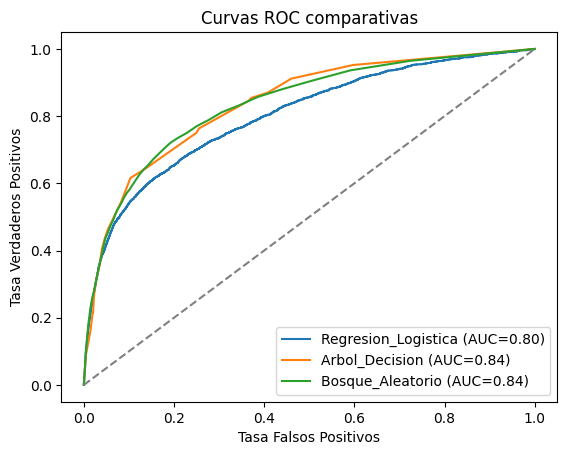

In [ ]:
modelos = {
    "Regresion_Logistica": LogisticRegression(max_iter=500),
    "Arbol_Decision": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Bosque_Aleatorio": RandomForestClassifier(n_estimators=100, random_state=42)
}

for nombre, modelo in modelos.items():
    modelo.fit(X_entrenamiento_bal, y_entrenamiento_bal)
    pred = modelo.predict(X_prueba)
    prob = modelo.predict_proba(X_prueba)[:, 1]
    print(f"\nModelo: {nombre}")
    print(classification_report(y_prueba, pred))
    print("AUC-ROC:", roc_auc_score(y_prueba, prob))
    fpr, tpr, _ = roc_curve(y_prueba, prob)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={roc_auc_score(y_prueba, prob):.2f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.title("Curvas ROC comparativas")
plt.xlabel("Tasa Falsos Positivos")
plt.ylabel("Tasa Verdaderos Positivos")
plt.legend()
plt.show()


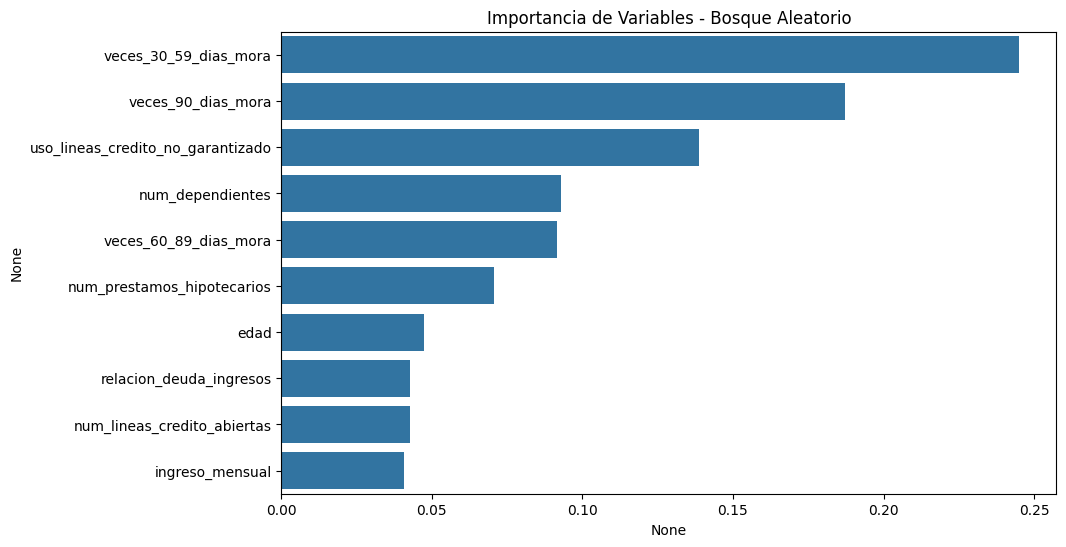

In [25]:
importancias = modelos["Bosque_Aleatorio"].feature_importances_
importancia_vars = pd.Series(importancias, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importancia_vars[:10], y=importancia_vars.index[:10])
plt.title("Importancia de Variables - Bosque Aleatorio")
plt.show()

importancia_vars.to_excel("importancia_variables.xlsx", index=True)